In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym as gym
from gym import spaces

In [30]:
# Load dataset
df = pd.read_csv("metrics-with-output.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [31]:
# Menampilkan baris pertama dari data set
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


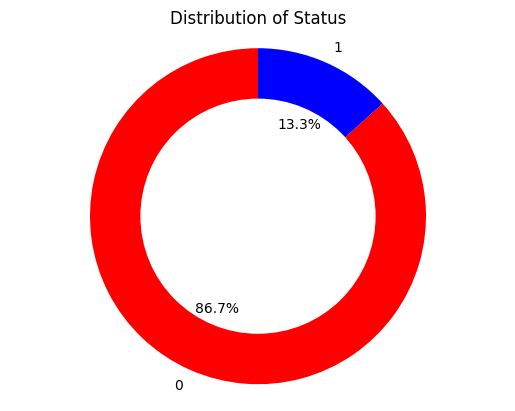

In [32]:
import matplotlib.pyplot as plt

# Membandingkan jumlah status healthy dan unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red', 'blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
# menambahkan lingkaran tengah untuk membuat donut chart
plt.gca().add_artist(plt.Circle((0,0), 0.70, fc='white'))
# memastikan lingkaran berukuran sama sehingga terlihat seperti donus
plt.axis('equal')

plt.title('Distribution of Status')
plt.show()

In [33]:
print(df.dtypes)

Time                  object
Timestamp              int64
cpu_usage             object
memory_usage          object
bandwidth_inbound     object
bandwidth_outbound    object
tps                   object
tps_error             object
response_time         object
Status                 int64
dtype: object


In [34]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype(float) / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [35]:
# Info dataset mengenai tipe, jumlah kolom, dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [36]:
# Menampilkan dataset setelah konversi
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [37]:
# Pembersihan dan penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)
dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [38]:
from sklearn.preprocessing import LabelEncoder

# Encode Status ke numerik
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [39]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [40]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Terdapat missing values yang perlu diimputasi")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset")

Tidak ada missing values dalam dataset


In [41]:
# Split data menjadi feature (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [42]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [44]:
# Mendefinisikan model ppo
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(p=0.3)  # Menambahkan dropout

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PPO:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.95, k_epochs=5, eps_clip=0.1):
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = PolicyNetwork(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = torch.softmax(self.policy_old(state), dim=-1)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
    
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        old_states = torch.squeeze(torch.stack(memory.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(memory.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs, dim=0)).detach().to(device)
        
        for _ in range(self.k_epochs):
            action_probs = torch.softmax(self.policy(old_states), dim=-1)
            dist = Categorical(action_probs)
            logprobs = dist.log_prob(old_actions)
            entropy = dist.entropy()
            
            ratios = torch.exp(logprobs - old_logprobs)
            
            advantages = rewards - rewards.mean()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            state_values = self.policy(old_states).max(dim=1).values
            
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*entropy.mean()
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())



class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

    def add_action(self, action):
        self.actions.append(action)

    def add_state(self, state):
        self.states.append(state)

    def add_logprob(self, logprob):
        self.logprobs.append(logprob)

    def add_reward(self, reward):
        self.rewards.append(reward)

    def add_is_terminal(self, is_terminal):
        self.is_terminals.append(is_terminal)


In [45]:
# Mendefinisikan Environment
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Load data dari data set
        self.df = dataset

        # Mendefinisikan action dan observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float64)

        self.curent_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()
    
    def step(self):
        self.curent_step += 1
        done = self.curent_step >= len(self.df) - 1

        reward = self._get_reward()
        next_state = self._get_observation()
        
        return next_state, reward, done, {}
    
    def _get_observation(self):
        return self.df.iloc[self.current_step][['cpu_usage', 'memory_usage', 'bandwidth_inbound', 'bandwidth_outbound', 'tps', 'tps_error', 'response_time']].values
    
    def _get_reward(self):
        if self.df.iloc[self.current_step]['Status'] == 0:
            return 1.0
        else:
            return -1.0


In [46]:
len(dataset)

7189

In [47]:
# Training Model PPO

env = CustomEnv()

# Use the custom environment with the PPO algorithm
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo = PPO(state_dim, action_dim)
memory = Memory()

max_episodes = 1800
max_timesteps = 2000
update_timestep = 2000
print_freq = 1

time_step = 0
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for t in range(max_timesteps):
        time_step += 1
        action, logprob = ppo.select_action(state)
        next_state, reward, done, _ = env.step()


        # memory.add_state(torch.FloatTensor(state))
        memory.add_state(torch.FloatTensor(state))
        memory.add_action(torch.tensor(action))
        memory.add_logprob(torch.tensor(logprob))
        memory.add_reward(reward)
        memory.add_is_terminal(done)
        
        state = next_state
        episode_reward += reward


        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        
        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % print_freq == 0:
        print("Episode {} \t Total reward: {}".format(episode, episode_reward))

    
        

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1 	 Total reward: 2000.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 2 	 Total reward: 2000.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 3 	 Total reward: 2000.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 4 	 Total reward: 1188.0
Episode 5 	 Total reward: 1.0
Episode 6 	 Total reward: 1.0
Episode 7 	 Total reward: 1.0
Episode 8 	 Total reward: 1.0
Episode 9 	 Total reward: 1.0
Episode 10 	 Total reward: 1.0
Episode 11 	 Total reward: 1.0
Episode 12 	 Total reward: 1.0
Episode 13 	 Total reward: 1.0
Episode 14 	 Total reward: 1.0
Episode 15 	 Total reward: 1.0
Episode 16 	 Total reward: 1.0
Episode 17 	 Total reward: 1.0
Episode 18 	 Total reward: 1.0
Episode 19 	 Total reward: 1.0
Episode 20 	 Total reward: 1.0
Episode 21 	 Total reward: 1.0
Episode 22 	 Total reward: 1.0
Episode 23 	 Total reward: 1.0
Episode 24 	 Total reward: 1.0
Episode 25 	 Total reward: 1.0
Episode 26 	 Total reward: 1.0
Episode 27 	 Total reward: 1.0
Episode 28 	 Total reward: 1.0
Episode 29 	 Total reward: 1.0
Episode 30 	 Total reward: 1.0
Episode 31 	 Total reward: 1.0
Episode 32 	 Total reward: 1.0
Episode 33 	 Total reward: 1.0
Episode 34 	 Total reward: 1.0
Episode 35 	 Total reward: 1.0
Episode 36 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 49 	 Total reward: 1.0
Episode 50 	 Total reward: 1.0
Episode 51 	 Total reward: 1.0
Episode 52 	 Total reward: 1.0
Episode 53 	 Total reward: 1.0
Episode 54 	 Total reward: 1.0
Episode 55 	 Total reward: 1.0
Episode 56 	 Total reward: 1.0
Episode 57 	 Total reward: 1.0
Episode 58 	 Total reward: 1.0
Episode 59 	 Total reward: 1.0
Episode 60 	 Total reward: 1.0
Episode 61 	 Total reward: 1.0
Episode 62 	 Total reward: 1.0
Episode 63 	 Total reward: 1.0
Episode 64 	 Total reward: 1.0
Episode 65 	 Total reward: 1.0
Episode 66 	 Total reward: 1.0
Episode 67 	 Total reward: 1.0
Episode 68 	 Total reward: 1.0
Episode 69 	 Total reward: 1.0
Episode 70 	 Total reward: 1.0
Episode 71 	 Total reward: 1.0
Episode 72 	 Total reward: 1.0
Episode 73 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 74 	 Total reward: 1.0
Episode 75 	 Total reward: 1.0
Episode 76 	 Total reward: 1.0
Episode 77 	 Total reward: 1.0
Episode 78 	 Total reward: 1.0
Episode 79 	 Total reward: 1.0
Episode 80 	 Total reward: 1.0
Episode 81 	 Total reward: 1.0
Episode 82 	 Total reward: 1.0
Episode 83 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 84 	 Total reward: 1.0
Episode 85 	 Total reward: 1.0
Episode 86 	 Total reward: 1.0
Episode 87 	 Total reward: 1.0
Episode 88 	 Total reward: 1.0
Episode 89 	 Total reward: 1.0
Episode 90 	 Total reward: 1.0
Episode 91 	 Total reward: 1.0
Episode 92 	 Total reward: 1.0
Episode 93 	 Total reward: 1.0
Episode 94 	 Total reward: 1.0
Episode 95 	 Total reward: 1.0
Episode 96 	 Total reward: 1.0
Episode 97 	 Total reward: 1.0
Episode 98 	 Total reward: 1.0
Episode 99 	 Total reward: 1.0
Episode 100 	 Total reward: 1.0
Episode 101 	 Total reward: 1.0
Episode 102 	 Total reward: 1.0
Episode 103 	 Total reward: 1.0
Episode 104 	 Total reward: 1.0
Episode 105 	 Total reward: 1.0
Episode 106 	 Total reward: 1.0
Episode 107 	 Total reward: 1.0
Episode 108 	 Total reward: 1.0
Episode 109 	 Total reward: 1.0
Episode 110 	 Total reward: 1.0
Episode 111 	 Total reward: 1.0
Episode 112 	 Total reward: 1.0
Episode 113 	 Total reward: 1.0
Episode 114 	 Total reward: 1.0
Episode 115 	 Total rewa

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 116 	 Total reward: 1.0
Episode 117 	 Total reward: 1.0
Episode 118 	 Total reward: 1.0
Episode 119 	 Total reward: 1.0
Episode 120 	 Total reward: 1.0
Episode 121 	 Total reward: 1.0
Episode 122 	 Total reward: 1.0
Episode 123 	 Total reward: 1.0
Episode 124 	 Total reward: 1.0
Episode 125 	 Total reward: 1.0
Episode 126 	 Total reward: 1.0
Episode 127 	 Total reward: 1.0
Episode 128 	 Total reward: 1.0
Episode 129 	 Total reward: 1.0
Episode 130 	 Total reward: 1.0
Episode 131 	 Total reward: 1.0
Episode 132 	 Total reward: 1.0
Episode 133 	 Total reward: 1.0
Episode 134 	 Total reward: 1.0
Episode 135 	 Total reward: 1.0
Episode 136 	 Total reward: 1.0
Episode 137 	 Total reward: 1.0
Episode 138 	 Total reward: 1.0
Episode 139 	 Total reward: 1.0
Episode 140 	 Total reward: 1.0
Episode 141 	 Total reward: 1.0
Episode 142 	 Total reward: 1.0
Episode 143 	 Total reward: 1.0
Episode 144 	 Total reward: 1.0
Episode 145 	 Total reward: 1.0
Episode 146 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 149 	 Total reward: 1.0
Episode 150 	 Total reward: 1.0
Episode 151 	 Total reward: 1.0
Episode 152 	 Total reward: 1.0
Episode 153 	 Total reward: 1.0
Episode 154 	 Total reward: 1.0
Episode 155 	 Total reward: 1.0
Episode 156 	 Total reward: 1.0
Episode 157 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 158 	 Total reward: 1.0
Episode 159 	 Total reward: 1.0
Episode 160 	 Total reward: 1.0
Episode 161 	 Total reward: 1.0
Episode 162 	 Total reward: 1.0
Episode 163 	 Total reward: 1.0
Episode 164 	 Total reward: 1.0
Episode 165 	 Total reward: 1.0
Episode 166 	 Total reward: 1.0
Episode 167 	 Total reward: 1.0
Episode 168 	 Total reward: 1.0
Episode 169 	 Total reward: 1.0
Episode 170 	 Total reward: 1.0
Episode 171 	 Total reward: 1.0
Episode 172 	 Total reward: 1.0
Episode 173 	 Total reward: 1.0
Episode 174 	 Total reward: 1.0
Episode 175 	 Total reward: 1.0
Episode 176 	 Total reward: 1.0
Episode 177 	 Total reward: 1.0
Episode 178 	 Total reward: 1.0
Episode 179 	 Total reward: 1.0
Episode 180 	 Total reward: 1.0
Episode 181 	 Total reward: 1.0
Episode 182 	 Total reward: 1.0
Episode 183 	 Total reward: 1.0
Episode 184 	 Total reward: 1.0
Episode 185 	 Total reward: 1.0
Episode 186 	 Total reward: 1.0
Episode 187 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 188 	 Total reward: 1.0
Episode 189 	 Total reward: 1.0
Episode 190 	 Total reward: 1.0
Episode 191 	 Total reward: 1.0
Episode 192 	 Total reward: 1.0
Episode 193 	 Total reward: 1.0
Episode 194 	 Total reward: 1.0
Episode 195 	 Total reward: 1.0
Episode 196 	 Total reward: 1.0
Episode 197 	 Total reward: 1.0
Episode 198 	 Total reward: 1.0
Episode 199 	 Total reward: 1.0
Episode 200 	 Total reward: 1.0
Episode 201 	 Total reward: 1.0
Episode 202 	 Total reward: 1.0
Episode 203 	 Total reward: 1.0
Episode 204 	 Total reward: 1.0
Episode 205 	 Total reward: 1.0
Episode 206 	 Total reward: 1.0
Episode 207 	 Total reward: 1.0
Episode 208 	 Total reward: 1.0
Episode 209 	 Total reward: 1.0
Episode 210 	 Total reward: 1.0
Episode 211 	 Total reward: 1.0
Episode 212 	 Total reward: 1.0
Episode 213 	 Total reward: 1.0
Episode 214 	 Total reward: 1.0
Episode 215 	 Total reward: 1.0
Episode 216 	 Total reward: 1.0
Episode 217 	 Total reward: 1.0
Episode 218 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 221 	 Total reward: 1.0
Episode 222 	 Total reward: 1.0
Episode 223 	 Total reward: 1.0
Episode 224 	 Total reward: 1.0
Episode 225 	 Total reward: 1.0
Episode 226 	 Total reward: 1.0
Episode 227 	 Total reward: 1.0
Episode 228 	 Total reward: 1.0
Episode 229 	 Total reward: 1.0
Episode 230 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 231 	 Total reward: 1.0
Episode 232 	 Total reward: 1.0
Episode 233 	 Total reward: 1.0
Episode 234 	 Total reward: 1.0
Episode 235 	 Total reward: 1.0
Episode 236 	 Total reward: 1.0
Episode 237 	 Total reward: 1.0
Episode 238 	 Total reward: 1.0
Episode 239 	 Total reward: 1.0
Episode 240 	 Total reward: 1.0
Episode 241 	 Total reward: 1.0
Episode 242 	 Total reward: 1.0
Episode 243 	 Total reward: 1.0
Episode 244 	 Total reward: 1.0
Episode 245 	 Total reward: 1.0
Episode 246 	 Total reward: 1.0
Episode 247 	 Total reward: 1.0
Episode 248 	 Total reward: 1.0
Episode 249 	 Total reward: 1.0
Episode 250 	 Total reward: 1.0
Episode 251 	 Total reward: 1.0
Episode 252 	 Total reward: 1.0
Episode 253 	 Total reward: 1.0
Episode 254 	 Total reward: 1.0
Episode 255 	 Total reward: 1.0
Episode 256 	 Total reward: 1.0
Episode 257 	 Total reward: 1.0
Episode 258 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 259 	 Total reward: 1.0
Episode 260 	 Total reward: 1.0
Episode 261 	 Total reward: 1.0
Episode 262 	 Total reward: 1.0
Episode 263 	 Total reward: 1.0
Episode 264 	 Total reward: 1.0
Episode 265 	 Total reward: 1.0
Episode 266 	 Total reward: 1.0
Episode 267 	 Total reward: 1.0
Episode 268 	 Total reward: 1.0
Episode 269 	 Total reward: 1.0
Episode 270 	 Total reward: 1.0
Episode 271 	 Total reward: 1.0
Episode 272 	 Total reward: 1.0
Episode 273 	 Total reward: 1.0
Episode 274 	 Total reward: 1.0
Episode 275 	 Total reward: 1.0
Episode 276 	 Total reward: 1.0
Episode 277 	 Total reward: 1.0
Episode 278 	 Total reward: 1.0
Episode 279 	 Total reward: 1.0
Episode 280 	 Total reward: 1.0
Episode 281 	 Total reward: 1.0
Episode 282 	 Total reward: 1.0
Episode 283 	 Total reward: 1.0
Episode 284 	 Total reward: 1.0
Episode 285 	 Total reward: 1.0
Episode 286 	 Total reward: 1.0
Episode 287 	 Total reward: 1.0
Episode 288 	 Total reward: 1.0
Episode 289 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 295 	 Total reward: 1.0
Episode 296 	 Total reward: 1.0
Episode 297 	 Total reward: 1.0
Episode 298 	 Total reward: 1.0
Episode 299 	 Total reward: 1.0
Episode 300 	 Total reward: 1.0
Episode 301 	 Total reward: 1.0
Episode 302 	 Total reward: 1.0
Episode 303 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 304 	 Total reward: 1.0
Episode 305 	 Total reward: 1.0
Episode 306 	 Total reward: 1.0
Episode 307 	 Total reward: 1.0
Episode 308 	 Total reward: 1.0
Episode 309 	 Total reward: 1.0
Episode 310 	 Total reward: 1.0
Episode 311 	 Total reward: 1.0
Episode 312 	 Total reward: 1.0
Episode 313 	 Total reward: 1.0
Episode 314 	 Total reward: 1.0
Episode 315 	 Total reward: 1.0
Episode 316 	 Total reward: 1.0
Episode 317 	 Total reward: 1.0
Episode 318 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 319 	 Total reward: 1.0
Episode 320 	 Total reward: 1.0
Episode 321 	 Total reward: 1.0
Episode 322 	 Total reward: 1.0
Episode 323 	 Total reward: 1.0
Episode 324 	 Total reward: 1.0
Episode 325 	 Total reward: 1.0
Episode 326 	 Total reward: 1.0
Episode 327 	 Total reward: 1.0
Episode 328 	 Total reward: 1.0
Episode 329 	 Total reward: 1.0
Episode 330 	 Total reward: 1.0
Episode 331 	 Total reward: 1.0
Episode 332 	 Total reward: 1.0
Episode 333 	 Total reward: 1.0
Episode 334 	 Total reward: 1.0
Episode 335 	 Total reward: 1.0
Episode 336 	 Total reward: 1.0
Episode 337 	 Total reward: 1.0
Episode 338 	 Total reward: 1.0
Episode 339 	 Total reward: 1.0
Episode 340 	 Total reward: 1.0
Episode 341 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 342 	 Total reward: 1.0
Episode 343 	 Total reward: 1.0
Episode 344 	 Total reward: 1.0
Episode 345 	 Total reward: 1.0
Episode 346 	 Total reward: 1.0
Episode 347 	 Total reward: 1.0
Episode 348 	 Total reward: 1.0
Episode 349 	 Total reward: 1.0
Episode 350 	 Total reward: 1.0
Episode 351 	 Total reward: 1.0
Episode 352 	 Total reward: 1.0
Episode 353 	 Total reward: 1.0
Episode 354 	 Total reward: 1.0
Episode 355 	 Total reward: 1.0
Episode 356 	 Total reward: 1.0
Episode 357 	 Total reward: 1.0
Episode 358 	 Total reward: 1.0
Episode 359 	 Total reward: 1.0
Episode 360 	 Total reward: 1.0
Episode 361 	 Total reward: 1.0
Episode 362 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 363 	 Total reward: 1.0
Episode 364 	 Total reward: 1.0
Episode 365 	 Total reward: 1.0
Episode 366 	 Total reward: 1.0
Episode 367 	 Total reward: 1.0
Episode 368 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 369 	 Total reward: 1.0
Episode 370 	 Total reward: 1.0
Episode 371 	 Total reward: 1.0
Episode 372 	 Total reward: 1.0
Episode 373 	 Total reward: 1.0
Episode 374 	 Total reward: 1.0
Episode 375 	 Total reward: 1.0
Episode 376 	 Total reward: 1.0
Episode 377 	 Total reward: 1.0
Episode 378 	 Total reward: 1.0
Episode 379 	 Total reward: 1.0
Episode 380 	 Total reward: 1.0
Episode 381 	 Total reward: 1.0
Episode 382 	 Total reward: 1.0
Episode 383 	 Total reward: 1.0
Episode 384 	 Total reward: 1.0
Episode 385 	 Total reward: 1.0
Episode 386 	 Total reward: 1.0
Episode 387 	 Total reward: 1.0
Episode 388 	 Total reward: 1.0
Episode 389 	 Total reward: 1.0
Episode 390 	 Total reward: 1.0
Episode 391 	 Total reward: 1.0
Episode 392 	 Total reward: 1.0
Episode 393 	 Total reward: 1.0
Episode 394 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 395 	 Total reward: 1.0
Episode 396 	 Total reward: 1.0
Episode 397 	 Total reward: 1.0
Episode 398 	 Total reward: 1.0
Episode 399 	 Total reward: 1.0
Episode 400 	 Total reward: 1.0
Episode 401 	 Total reward: 1.0
Episode 402 	 Total reward: 1.0
Episode 403 	 Total reward: 1.0
Episode 404 	 Total reward: 1.0
Episode 405 	 Total reward: 1.0
Episode 406 	 Total reward: 1.0
Episode 407 	 Total reward: 1.0
Episode 408 	 Total reward: 1.0
Episode 409 	 Total reward: 1.0
Episode 410 	 Total reward: 1.0
Episode 411 	 Total reward: 1.0
Episode 412 	 Total reward: 1.0
Episode 413 	 Total reward: 1.0
Episode 414 	 Total reward: 1.0
Episode 415 	 Total reward: 1.0
Episode 416 	 Total reward: 1.0
Episode 417 	 Total reward: 1.0
Episode 418 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 419 	 Total reward: 1.0
Episode 420 	 Total reward: 1.0
Episode 421 	 Total reward: 1.0
Episode 422 	 Total reward: 1.0
Episode 423 	 Total reward: 1.0
Episode 424 	 Total reward: 1.0
Episode 425 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 426 	 Total reward: 1.0
Episode 427 	 Total reward: 1.0
Episode 428 	 Total reward: 1.0
Episode 429 	 Total reward: 1.0
Episode 430 	 Total reward: 1.0
Episode 431 	 Total reward: 1.0
Episode 432 	 Total reward: 1.0
Episode 433 	 Total reward: 1.0
Episode 434 	 Total reward: 1.0
Episode 435 	 Total reward: 1.0
Episode 436 	 Total reward: 1.0
Episode 437 	 Total reward: 1.0
Episode 438 	 Total reward: 1.0
Episode 439 	 Total reward: 1.0
Episode 440 	 Total reward: 1.0
Episode 441 	 Total reward: 1.0
Episode 442 	 Total reward: 1.0
Episode 443 	 Total reward: 1.0
Episode 444 	 Total reward: 1.0
Episode 445 	 Total reward: 1.0
Episode 446 	 Total reward: 1.0
Episode 447 	 Total reward: 1.0
Episode 448 	 Total reward: 1.0
Episode 449 	 Total reward: 1.0
Episode 450 	 Total reward: 1.0
Episode 451 	 Total reward: 1.0
Episode 452 	 Total reward: 1.0
Episode 453 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 454 	 Total reward: 1.0
Episode 455 	 Total reward: 1.0
Episode 456 	 Total reward: 1.0
Episode 457 	 Total reward: 1.0
Episode 458 	 Total reward: 1.0
Episode 459 	 Total reward: 1.0
Episode 460 	 Total reward: 1.0
Episode 461 	 Total reward: 1.0
Episode 462 	 Total reward: 1.0
Episode 463 	 Total reward: 1.0
Episode 464 	 Total reward: 1.0
Episode 465 	 Total reward: 1.0
Episode 466 	 Total reward: 1.0
Episode 467 	 Total reward: 1.0
Episode 468 	 Total reward: 1.0
Episode 469 	 Total reward: 1.0
Episode 470 	 Total reward: 1.0
Episode 471 	 Total reward: 1.0
Episode 472 	 Total reward: 1.0
Episode 473 	 Total reward: 1.0
Episode 474 	 Total reward: 1.0
Episode 475 	 Total reward: 1.0
Episode 476 	 Total reward: 1.0
Episode 477 	 Total reward: 1.0
Episode 478 	 Total reward: 1.0
Episode 479 	 Total reward: 1.0
Episode 480 	 Total reward: 1.0
Episode 481 	 Total reward: 1.0
Episode 482 	 Total reward: 1.0
Episode 483 	 Total reward: 1.0
Episode 484 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 486 	 Total reward: 1.0
Episode 487 	 Total reward: 1.0
Episode 488 	 Total reward: 1.0
Episode 489 	 Total reward: 1.0
Episode 490 	 Total reward: 1.0
Episode 491 	 Total reward: 1.0
Episode 492 	 Total reward: 1.0
Episode 493 	 Total reward: 1.0
Episode 494 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 495 	 Total reward: 1.0
Episode 496 	 Total reward: 1.0
Episode 497 	 Total reward: 1.0
Episode 498 	 Total reward: 1.0
Episode 499 	 Total reward: 1.0
Episode 500 	 Total reward: 1.0
Episode 501 	 Total reward: 1.0
Episode 502 	 Total reward: 1.0
Episode 503 	 Total reward: 1.0
Episode 504 	 Total reward: 1.0
Episode 505 	 Total reward: 1.0
Episode 506 	 Total reward: 1.0
Episode 507 	 Total reward: 1.0
Episode 508 	 Total reward: 1.0
Episode 509 	 Total reward: 1.0
Episode 510 	 Total reward: 1.0
Episode 511 	 Total reward: 1.0
Episode 512 	 Total reward: 1.0
Episode 513 	 Total reward: 1.0
Episode 514 	 Total reward: 1.0
Episode 515 	 Total reward: 1.0
Episode 516 	 Total reward: 1.0
Episode 517 	 Total reward: 1.0
Episode 518 	 Total reward: 1.0
Episode 519 	 Total reward: 1.0
Episode 520 	 Total reward: 1.0
Episode 521 	 Total reward: 1.0
Episode 522 	 Total reward: 1.0
Episode 523 	 Total reward: 1.0
Episode 524 	 Total reward: 1.0
Episode 525 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 530 	 Total reward: 1.0
Episode 531 	 Total reward: 1.0
Episode 532 	 Total reward: 1.0
Episode 533 	 Total reward: 1.0
Episode 534 	 Total reward: 1.0
Episode 535 	 Total reward: 1.0
Episode 536 	 Total reward: 1.0
Episode 537 	 Total reward: 1.0
Episode 538 	 Total reward: 1.0
Episode 539 	 Total reward: 1.0
Episode 540 	 Total reward: 1.0
Episode 541 	 Total reward: 1.0
Episode 542 	 Total reward: 1.0
Episode 543 	 Total reward: 1.0
Episode 544 	 Total reward: 1.0
Episode 545 	 Total reward: 1.0
Episode 546 	 Total reward: 1.0
Episode 547 	 Total reward: 1.0
Episode 548 	 Total reward: 1.0
Episode 549 	 Total reward: 1.0
Episode 550 	 Total reward: 1.0
Episode 551 	 Total reward: 1.0
Episode 552 	 Total reward: 1.0
Episode 553 	 Total reward: 1.0
Episode 554 	 Total reward: 1.0
Episode 555 	 Total reward: 1.0
Episode 556 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 557 	 Total reward: 1.0
Episode 558 	 Total reward: 1.0
Episode 559 	 Total reward: 1.0
Episode 560 	 Total reward: 1.0
Episode 561 	 Total reward: 1.0
Episode 562 	 Total reward: 1.0
Episode 563 	 Total reward: 1.0
Episode 564 	 Total reward: 1.0
Episode 565 	 Total reward: 1.0
Episode 566 	 Total reward: 1.0
Episode 567 	 Total reward: 1.0
Episode 568 	 Total reward: 1.0
Episode 569 	 Total reward: 1.0
Episode 570 	 Total reward: 1.0
Episode 571 	 Total reward: 1.0
Episode 572 	 Total reward: 1.0
Episode 573 	 Total reward: 1.0
Episode 574 	 Total reward: 1.0
Episode 575 	 Total reward: 1.0
Episode 576 	 Total reward: 1.0
Episode 577 	 Total reward: 1.0
Episode 578 	 Total reward: 1.0
Episode 579 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 580 	 Total reward: 1.0
Episode 581 	 Total reward: 1.0
Episode 582 	 Total reward: 1.0
Episode 583 	 Total reward: 1.0
Episode 584 	 Total reward: 1.0
Episode 585 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 586 	 Total reward: 1.0
Episode 587 	 Total reward: 1.0
Episode 588 	 Total reward: 1.0
Episode 589 	 Total reward: 1.0
Episode 590 	 Total reward: 1.0
Episode 591 	 Total reward: 1.0
Episode 592 	 Total reward: 1.0
Episode 593 	 Total reward: 1.0
Episode 594 	 Total reward: 1.0
Episode 595 	 Total reward: 1.0
Episode 596 	 Total reward: 1.0
Episode 597 	 Total reward: 1.0
Episode 598 	 Total reward: 1.0
Episode 599 	 Total reward: 1.0
Episode 600 	 Total reward: 1.0
Episode 601 	 Total reward: 1.0
Episode 602 	 Total reward: 1.0
Episode 603 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 604 	 Total reward: 1.0
Episode 605 	 Total reward: 1.0
Episode 606 	 Total reward: 1.0
Episode 607 	 Total reward: 1.0
Episode 608 	 Total reward: 1.0
Episode 609 	 Total reward: 1.0
Episode 610 	 Total reward: 1.0
Episode 611 	 Total reward: 1.0
Episode 612 	 Total reward: 1.0
Episode 613 	 Total reward: 1.0
Episode 614 	 Total reward: 1.0
Episode 615 	 Total reward: 1.0
Episode 616 	 Total reward: 1.0
Episode 617 	 Total reward: 1.0
Episode 618 	 Total reward: 1.0
Episode 619 	 Total reward: 1.0
Episode 620 	 Total reward: 1.0
Episode 621 	 Total reward: 1.0
Episode 622 	 Total reward: 1.0
Episode 623 	 Total reward: 1.0
Episode 624 	 Total reward: 1.0
Episode 625 	 Total reward: 1.0
Episode 626 	 Total reward: 1.0
Episode 627 	 Total reward: 1.0
Episode 628 	 Total reward: 1.0
Episode 629 	 Total reward: 1.0
Episode 630 	 Total reward: 1.0
Episode 631 	 Total reward: 1.0
Episode 632 	 Total reward: 1.0
Episode 633 	 Total reward: 1.0
Episode 634 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 641 	 Total reward: 1.0
Episode 642 	 Total reward: 1.0
Episode 643 	 Total reward: 1.0
Episode 644 	 Total reward: 1.0
Episode 645 	 Total reward: 1.0
Episode 646 	 Total reward: 1.0
Episode 647 	 Total reward: 1.0
Episode 648 	 Total reward: 1.0
Episode 649 	 Total reward: 1.0
Episode 650 	 Total reward: 1.0
Episode 651 	 Total reward: 1.0
Episode 652 	 Total reward: 1.0
Episode 653 	 Total reward: 1.0
Episode 654 	 Total reward: 1.0
Episode 655 	 Total reward: 1.0
Episode 656 	 Total reward: 1.0
Episode 657 	 Total reward: 1.0
Episode 658 	 Total reward: 1.0
Episode 659 	 Total reward: 1.0
Episode 660 	 Total reward: 1.0
Episode 661 	 Total reward: 1.0
Episode 662 	 Total reward: 1.0
Episode 663 	 Total reward: 1.0
Episode 664 	 Total reward: 1.0
Episode 665 	 Total reward: 1.0
Episode 666 	 Total reward: 1.0
Episode 667 	 Total reward: 1.0
Episode 668 	 Total reward: 1.0
Episode 669 	 Total reward: 1.0
Episode 670 	 Total reward: 1.0
Episode 671 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 681 	 Total reward: 1.0
Episode 682 	 Total reward: 1.0
Episode 683 	 Total reward: 1.0
Episode 684 	 Total reward: 1.0
Episode 685 	 Total reward: 1.0
Episode 686 	 Total reward: 1.0
Episode 687 	 Total reward: 1.0
Episode 688 	 Total reward: 1.0
Episode 689 	 Total reward: 1.0
Episode 690 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 691 	 Total reward: 1.0
Episode 692 	 Total reward: 1.0
Episode 693 	 Total reward: 1.0
Episode 694 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 695 	 Total reward: 1.0
Episode 696 	 Total reward: 1.0
Episode 697 	 Total reward: 1.0
Episode 698 	 Total reward: 1.0
Episode 699 	 Total reward: 1.0
Episode 700 	 Total reward: 1.0
Episode 701 	 Total reward: 1.0
Episode 702 	 Total reward: 1.0
Episode 703 	 Total reward: 1.0
Episode 704 	 Total reward: 1.0
Episode 705 	 Total reward: 1.0
Episode 706 	 Total reward: 1.0
Episode 707 	 Total reward: 1.0
Episode 708 	 Total reward: 1.0
Episode 709 	 Total reward: 1.0
Episode 710 	 Total reward: 1.0
Episode 711 	 Total reward: 1.0
Episode 712 	 Total reward: 1.0
Episode 713 	 Total reward: 1.0
Episode 714 	 Total reward: 1.0
Episode 715 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 716 	 Total reward: 1.0
Episode 717 	 Total reward: 1.0
Episode 718 	 Total reward: 1.0
Episode 719 	 Total reward: 1.0
Episode 720 	 Total reward: 1.0
Episode 721 	 Total reward: 1.0
Episode 722 	 Total reward: 1.0
Episode 723 	 Total reward: 1.0
Episode 724 	 Total reward: 1.0
Episode 725 	 Total reward: 1.0
Episode 726 	 Total reward: 1.0
Episode 727 	 Total reward: 1.0
Episode 728 	 Total reward: 1.0
Episode 729 	 Total reward: 1.0
Episode 730 	 Total reward: 1.0
Episode 731 	 Total reward: 1.0
Episode 732 	 Total reward: 1.0
Episode 733 	 Total reward: 1.0
Episode 734 	 Total reward: 1.0
Episode 735 	 Total reward: 1.0
Episode 736 	 Total reward: 1.0
Episode 737 	 Total reward: 1.0
Episode 738 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 739 	 Total reward: 1.0
Episode 740 	 Total reward: 1.0
Episode 741 	 Total reward: 1.0
Episode 742 	 Total reward: 1.0
Episode 743 	 Total reward: 1.0
Episode 744 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 745 	 Total reward: 1.0
Episode 746 	 Total reward: 1.0
Episode 747 	 Total reward: 1.0
Episode 748 	 Total reward: 1.0
Episode 749 	 Total reward: 1.0
Episode 750 	 Total reward: 1.0
Episode 751 	 Total reward: 1.0
Episode 752 	 Total reward: 1.0
Episode 753 	 Total reward: 1.0
Episode 754 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 755 	 Total reward: 1.0
Episode 756 	 Total reward: 1.0
Episode 757 	 Total reward: 1.0
Episode 758 	 Total reward: 1.0
Episode 759 	 Total reward: 1.0
Episode 760 	 Total reward: 1.0
Episode 761 	 Total reward: 1.0
Episode 762 	 Total reward: 1.0
Episode 763 	 Total reward: 1.0
Episode 764 	 Total reward: 1.0
Episode 765 	 Total reward: 1.0
Episode 766 	 Total reward: 1.0
Episode 767 	 Total reward: 1.0
Episode 768 	 Total reward: 1.0
Episode 769 	 Total reward: 1.0
Episode 770 	 Total reward: 1.0
Episode 771 	 Total reward: 1.0
Episode 772 	 Total reward: 1.0
Episode 773 	 Total reward: 1.0
Episode 774 	 Total reward: 1.0
Episode 775 	 Total reward: 1.0
Episode 776 	 Total reward: 1.0
Episode 777 	 Total reward: 1.0
Episode 778 	 Total reward: 1.0
Episode 779 	 Total reward: 1.0
Episode 780 	 Total reward: 1.0
Episode 781 	 Total reward: 1.0
Episode 782 	 Total reward: 1.0
Episode 783 	 Total reward: 1.0
Episode 784 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 785 	 Total reward: 1.0
Episode 786 	 Total reward: 1.0
Episode 787 	 Total reward: 1.0
Episode 788 	 Total reward: 1.0
Episode 789 	 Total reward: 1.0
Episode 790 	 Total reward: 1.0
Episode 791 	 Total reward: 1.0
Episode 792 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 793 	 Total reward: 1.0
Episode 794 	 Total reward: 1.0
Episode 795 	 Total reward: 1.0
Episode 796 	 Total reward: 1.0
Episode 797 	 Total reward: 1.0
Episode 798 	 Total reward: 1.0
Episode 799 	 Total reward: 1.0
Episode 800 	 Total reward: 1.0
Episode 801 	 Total reward: 1.0
Episode 802 	 Total reward: 1.0
Episode 803 	 Total reward: 1.0
Episode 804 	 Total reward: 1.0
Episode 805 	 Total reward: 1.0
Episode 806 	 Total reward: 1.0
Episode 807 	 Total reward: 1.0
Episode 808 	 Total reward: 1.0
Episode 809 	 Total reward: 1.0
Episode 810 	 Total reward: 1.0
Episode 811 	 Total reward: 1.0
Episode 812 	 Total reward: 1.0
Episode 813 	 Total reward: 1.0
Episode 814 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 815 	 Total reward: 1.0
Episode 816 	 Total reward: 1.0
Episode 817 	 Total reward: 1.0
Episode 818 	 Total reward: 1.0
Episode 819 	 Total reward: 1.0
Episode 820 	 Total reward: 1.0
Episode 821 	 Total reward: 1.0
Episode 822 	 Total reward: 1.0
Episode 823 	 Total reward: 1.0
Episode 824 	 Total reward: 1.0
Episode 825 	 Total reward: 1.0
Episode 826 	 Total reward: 1.0
Episode 827 	 Total reward: 1.0
Episode 828 	 Total reward: 1.0
Episode 829 	 Total reward: 1.0
Episode 830 	 Total reward: 1.0
Episode 831 	 Total reward: 1.0
Episode 832 	 Total reward: 1.0
Episode 833 	 Total reward: 1.0
Episode 834 	 Total reward: 1.0
Episode 835 	 Total reward: 1.0
Episode 836 	 Total reward: 1.0
Episode 837 	 Total reward: 1.0
Episode 838 	 Total reward: 1.0
Episode 839 	 Total reward: 1.0
Episode 840 	 Total reward: 1.0
Episode 841 	 Total reward: 1.0
Episode 842 	 Total reward: 1.0
Episode 843 	 Total reward: 1.0
Episode 844 	 Total reward: 1.0
Episode 845 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 850 	 Total reward: 1.0
Episode 851 	 Total reward: 1.0
Episode 852 	 Total reward: 1.0
Episode 853 	 Total reward: 1.0
Episode 854 	 Total reward: 1.0
Episode 855 	 Total reward: 1.0
Episode 856 	 Total reward: 1.0
Episode 857 	 Total reward: 1.0
Episode 858 	 Total reward: 1.0
Episode 859 	 Total reward: 1.0
Episode 860 	 Total reward: 1.0
Episode 861 	 Total reward: 1.0
Episode 862 	 Total reward: 1.0
Episode 863 	 Total reward: 1.0
Episode 864 	 Total reward: 1.0
Episode 865 	 Total reward: 1.0
Episode 866 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 867 	 Total reward: 1.0
Episode 868 	 Total reward: 1.0
Episode 869 	 Total reward: 1.0
Episode 870 	 Total reward: 1.0
Episode 871 	 Total reward: 1.0
Episode 872 	 Total reward: 1.0
Episode 873 	 Total reward: 1.0
Episode 874 	 Total reward: 1.0
Episode 875 	 Total reward: 1.0
Episode 876 	 Total reward: 1.0
Episode 877 	 Total reward: 1.0
Episode 878 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 879 	 Total reward: 1.0
Episode 880 	 Total reward: 1.0
Episode 881 	 Total reward: 1.0
Episode 882 	 Total reward: 1.0
Episode 883 	 Total reward: 1.0
Episode 884 	 Total reward: 1.0
Episode 885 	 Total reward: 1.0
Episode 886 	 Total reward: 1.0
Episode 887 	 Total reward: 1.0
Episode 888 	 Total reward: 1.0
Episode 889 	 Total reward: 1.0
Episode 890 	 Total reward: 1.0
Episode 891 	 Total reward: 1.0
Episode 892 	 Total reward: 1.0
Episode 893 	 Total reward: 1.0
Episode 894 	 Total reward: 1.0
Episode 895 	 Total reward: 1.0
Episode 896 	 Total reward: 1.0
Episode 897 	 Total reward: 1.0
Episode 898 	 Total reward: 1.0
Episode 899 	 Total reward: 1.0
Episode 900 	 Total reward: 1.0
Episode 901 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 902 	 Total reward: 1.0
Episode 903 	 Total reward: 1.0
Episode 904 	 Total reward: 1.0
Episode 905 	 Total reward: 1.0
Episode 906 	 Total reward: 1.0
Episode 907 	 Total reward: 1.0
Episode 908 	 Total reward: 1.0
Episode 909 	 Total reward: 1.0
Episode 910 	 Total reward: 1.0
Episode 911 	 Total reward: 1.0
Episode 912 	 Total reward: 1.0
Episode 913 	 Total reward: 1.0
Episode 914 	 Total reward: 1.0
Episode 915 	 Total reward: 1.0
Episode 916 	 Total reward: 1.0
Episode 917 	 Total reward: 1.0
Episode 918 	 Total reward: 1.0
Episode 919 	 Total reward: 1.0
Episode 920 	 Total reward: 1.0
Episode 921 	 Total reward: 1.0
Episode 922 	 Total reward: 1.0
Episode 923 	 Total reward: 1.0
Episode 924 	 Total reward: 1.0
Episode 925 	 Total reward: 1.0
Episode 926 	 Total reward: 1.0
Episode 927 	 Total reward: 1.0
Episode 928 	 Total reward: 1.0
Episode 929 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 930 	 Total reward: 1.0
Episode 931 	 Total reward: 1.0
Episode 932 	 Total reward: 1.0
Episode 933 	 Total reward: 1.0
Episode 934 	 Total reward: 1.0
Episode 935 	 Total reward: 1.0
Episode 936 	 Total reward: 1.0
Episode 937 	 Total reward: 1.0
Episode 938 	 Total reward: 1.0
Episode 939 	 Total reward: 1.0
Episode 940 	 Total reward: 1.0
Episode 941 	 Total reward: 1.0
Episode 942 	 Total reward: 1.0
Episode 943 	 Total reward: 1.0
Episode 944 	 Total reward: 1.0
Episode 945 	 Total reward: 1.0
Episode 946 	 Total reward: 1.0
Episode 947 	 Total reward: 1.0
Episode 948 	 Total reward: 1.0
Episode 949 	 Total reward: 1.0
Episode 950 	 Total reward: 1.0
Episode 951 	 Total reward: 1.0
Episode 952 	 Total reward: 1.0
Episode 953 	 Total reward: 1.0
Episode 954 	 Total reward: 1.0
Episode 955 	 Total reward: 1.0
Episode 956 	 Total reward: 1.0
Episode 957 	 Total reward: 1.0
Episode 958 	 Total reward: 1.0
Episode 959 	 Total reward: 1.0
Episode 960 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 964 	 Total reward: 1.0
Episode 965 	 Total reward: 1.0
Episode 966 	 Total reward: 1.0
Episode 967 	 Total reward: 1.0
Episode 968 	 Total reward: 1.0
Episode 969 	 Total reward: 1.0
Episode 970 	 Total reward: 1.0
Episode 971 	 Total reward: 1.0
Episode 972 	 Total reward: 1.0
Episode 973 	 Total reward: 1.0
Episode 974 	 Total reward: 1.0
Episode 975 	 Total reward: 1.0
Episode 976 	 Total reward: 1.0
Episode 977 	 Total reward: 1.0
Episode 978 	 Total reward: 1.0
Episode 979 	 Total reward: 1.0
Episode 980 	 Total reward: 1.0
Episode 981 	 Total reward: 1.0
Episode 982 	 Total reward: 1.0
Episode 983 	 Total reward: 1.0
Episode 984 	 Total reward: 1.0
Episode 985 	 Total reward: 1.0
Episode 986 	 Total reward: 1.0
Episode 987 	 Total reward: 1.0
Episode 988 	 Total reward: 1.0
Episode 989 	 Total reward: 1.0
Episode 990 	 Total reward: 1.0
Episode 991 	 Total reward: 1.0
Episode 992 	 Total reward: 1.0
Episode 993 	 Total reward: 1.0
Episode 994 	 Total reward: 1.0
Episode 

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 998 	 Total reward: 1.0
Episode 999 	 Total reward: 1.0
Episode 1000 	 Total reward: 1.0
Episode 1001 	 Total reward: 1.0
Episode 1002 	 Total reward: 1.0
Episode 1003 	 Total reward: 1.0
Episode 1004 	 Total reward: 1.0
Episode 1005 	 Total reward: 1.0
Episode 1006 	 Total reward: 1.0
Episode 1007 	 Total reward: 1.0
Episode 1008 	 Total reward: 1.0
Episode 1009 	 Total reward: 1.0
Episode 1010 	 Total reward: 1.0
Episode 1011 	 Total reward: 1.0
Episode 1012 	 Total reward: 1.0
Episode 1013 	 Total reward: 1.0
Episode 1014 	 Total reward: 1.0
Episode 1015 	 Total reward: 1.0
Episode 1016 	 Total reward: 1.0
Episode 1017 	 Total reward: 1.0
Episode 1018 	 Total reward: 1.0
Episode 1019 	 Total reward: 1.0
Episode 1020 	 Total reward: 1.0
Episode 1021 	 Total reward: 1.0
Episode 1022 	 Total reward: 1.0
Episode 1023 	 Total reward: 1.0
Episode 1024 	 Total reward: 1.0
Episode 1025 	 Total reward: 1.0
Episode 1026 	 Total reward: 1.0
Episode 1027 	 Total reward: 1.0
Episode 1028

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1031 	 Total reward: 1.0
Episode 1032 	 Total reward: 1.0
Episode 1033 	 Total reward: 1.0
Episode 1034 	 Total reward: 1.0
Episode 1035 	 Total reward: 1.0
Episode 1036 	 Total reward: 1.0
Episode 1037 	 Total reward: 1.0
Episode 1038 	 Total reward: 1.0
Episode 1039 	 Total reward: 1.0
Episode 1040 	 Total reward: 1.0
Episode 1041 	 Total reward: 1.0
Episode 1042 	 Total reward: 1.0
Episode 1043 	 Total reward: 1.0
Episode 1044 	 Total reward: 1.0
Episode 1045 	 Total reward: 1.0
Episode 1046 	 Total reward: 1.0
Episode 1047 	 Total reward: 1.0
Episode 1048 	 Total reward: 1.0
Episode 1049 	 Total reward: 1.0
Episode 1050 	 Total reward: 1.0
Episode 1051 	 Total reward: 1.0
Episode 1052 	 Total reward: 1.0
Episode 1053 	 Total reward: 1.0
Episode 1054 	 Total reward: 1.0
Episode 1055 	 Total reward: 1.0
Episode 1056 	 Total reward: 1.0
Episode 1057 	 Total reward: 1.0
Episode 1058 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1059 	 Total reward: 1.0
Episode 1060 	 Total reward: 1.0
Episode 1061 	 Total reward: 1.0
Episode 1062 	 Total reward: 1.0
Episode 1063 	 Total reward: 1.0
Episode 1064 	 Total reward: 1.0
Episode 1065 	 Total reward: 1.0
Episode 1066 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1067 	 Total reward: 1.0
Episode 1068 	 Total reward: 1.0
Episode 1069 	 Total reward: 1.0
Episode 1070 	 Total reward: 1.0
Episode 1071 	 Total reward: 1.0
Episode 1072 	 Total reward: 1.0
Episode 1073 	 Total reward: 1.0
Episode 1074 	 Total reward: 1.0
Episode 1075 	 Total reward: 1.0
Episode 1076 	 Total reward: 1.0
Episode 1077 	 Total reward: 1.0
Episode 1078 	 Total reward: 1.0
Episode 1079 	 Total reward: 1.0
Episode 1080 	 Total reward: 1.0
Episode 1081 	 Total reward: 1.0
Episode 1082 	 Total reward: 1.0
Episode 1083 	 Total reward: 1.0
Episode 1084 	 Total reward: 1.0
Episode 1085 	 Total reward: 1.0
Episode 1086 	 Total reward: 1.0
Episode 1087 	 Total reward: 1.0
Episode 1088 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1089 	 Total reward: 1.0
Episode 1090 	 Total reward: 1.0
Episode 1091 	 Total reward: 1.0
Episode 1092 	 Total reward: 1.0
Episode 1093 	 Total reward: 1.0
Episode 1094 	 Total reward: 1.0
Episode 1095 	 Total reward: 1.0
Episode 1096 	 Total reward: 1.0
Episode 1097 	 Total reward: 1.0
Episode 1098 	 Total reward: 1.0
Episode 1099 	 Total reward: 1.0
Episode 1100 	 Total reward: 1.0
Episode 1101 	 Total reward: 1.0
Episode 1102 	 Total reward: 1.0
Episode 1103 	 Total reward: 1.0
Episode 1104 	 Total reward: 1.0
Episode 1105 	 Total reward: 1.0
Episode 1106 	 Total reward: 1.0
Episode 1107 	 Total reward: 1.0
Episode 1108 	 Total reward: 1.0
Episode 1109 	 Total reward: 1.0
Episode 1110 	 Total reward: 1.0
Episode 1111 	 Total reward: 1.0
Episode 1112 	 Total reward: 1.0
Episode 1113 	 Total reward: 1.0
Episode 1114 	 Total reward: 1.0
Episode 1115 	 Total reward: 1.0
Episode 1116 	 Total reward: 1.0
Episode 1117 	 Total reward: 1.0
Episode 1118 	 Total reward: 1.0
Episode 11

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1124 	 Total reward: 1.0
Episode 1125 	 Total reward: 1.0
Episode 1126 	 Total reward: 1.0
Episode 1127 	 Total reward: 1.0
Episode 1128 	 Total reward: 1.0
Episode 1129 	 Total reward: 1.0
Episode 1130 	 Total reward: 1.0
Episode 1131 	 Total reward: 1.0
Episode 1132 	 Total reward: 1.0
Episode 1133 	 Total reward: 1.0
Episode 1134 	 Total reward: 1.0
Episode 1135 	 Total reward: 1.0
Episode 1136 	 Total reward: 1.0
Episode 1137 	 Total reward: 1.0
Episode 1138 	 Total reward: 1.0
Episode 1139 	 Total reward: 1.0
Episode 1140 	 Total reward: 1.0
Episode 1141 	 Total reward: 1.0
Episode 1142 	 Total reward: 1.0
Episode 1143 	 Total reward: 1.0
Episode 1144 	 Total reward: 1.0
Episode 1145 	 Total reward: 1.0
Episode 1146 	 Total reward: 1.0
Episode 1147 	 Total reward: 1.0
Episode 1148 	 Total reward: 1.0
Episode 1149 	 Total reward: 1.0
Episode 1150 	 Total reward: 1.0
Episode 1151 	 Total reward: 1.0
Episode 1152 	 Total reward: 1.0
Episode 1153 	 Total reward: 1.0
Episode 11

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1157 	 Total reward: 1.0
Episode 1158 	 Total reward: 1.0
Episode 1159 	 Total reward: 1.0
Episode 1160 	 Total reward: 1.0
Episode 1161 	 Total reward: 1.0
Episode 1162 	 Total reward: 1.0
Episode 1163 	 Total reward: 1.0
Episode 1164 	 Total reward: 1.0
Episode 1165 	 Total reward: 1.0
Episode 1166 	 Total reward: 1.0
Episode 1167 	 Total reward: 1.0
Episode 1168 	 Total reward: 1.0
Episode 1169 	 Total reward: 1.0
Episode 1170 	 Total reward: 1.0
Episode 1171 	 Total reward: 1.0
Episode 1172 	 Total reward: 1.0
Episode 1173 	 Total reward: 1.0
Episode 1174 	 Total reward: 1.0
Episode 1175 	 Total reward: 1.0
Episode 1176 	 Total reward: 1.0
Episode 1177 	 Total reward: 1.0
Episode 1178 	 Total reward: 1.0
Episode 1179 	 Total reward: 1.0
Episode 1180 	 Total reward: 1.0
Episode 1181 	 Total reward: 1.0
Episode 1182 	 Total reward: 1.0
Episode 1183 	 Total reward: 1.0
Episode 1184 	 Total reward: 1.0
Episode 1185 	 Total reward: 1.0
Episode 1186 	 Total reward: 1.0
Episode 11

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1193 	 Total reward: 1.0
Episode 1194 	 Total reward: 1.0
Episode 1195 	 Total reward: 1.0
Episode 1196 	 Total reward: 1.0
Episode 1197 	 Total reward: 1.0
Episode 1198 	 Total reward: 1.0
Episode 1199 	 Total reward: 1.0
Episode 1200 	 Total reward: 1.0
Episode 1201 	 Total reward: 1.0
Episode 1202 	 Total reward: 1.0
Episode 1203 	 Total reward: 1.0
Episode 1204 	 Total reward: 1.0
Episode 1205 	 Total reward: 1.0
Episode 1206 	 Total reward: 1.0
Episode 1207 	 Total reward: 1.0
Episode 1208 	 Total reward: 1.0
Episode 1209 	 Total reward: 1.0
Episode 1210 	 Total reward: 1.0
Episode 1211 	 Total reward: 1.0
Episode 1212 	 Total reward: 1.0
Episode 1213 	 Total reward: 1.0
Episode 1214 	 Total reward: 1.0
Episode 1215 	 Total reward: 1.0
Episode 1216 	 Total reward: 1.0
Episode 1217 	 Total reward: 1.0
Episode 1218 	 Total reward: 1.0
Episode 1219 	 Total reward: 1.0
Episode 1220 	 Total reward: 1.0
Episode 1221 	 Total reward: 1.0
Episode 1222 	 Total reward: 1.0
Episode 12

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1232 	 Total reward: 1.0
Episode 1233 	 Total reward: 1.0
Episode 1234 	 Total reward: 1.0
Episode 1235 	 Total reward: 1.0
Episode 1236 	 Total reward: 1.0
Episode 1237 	 Total reward: 1.0
Episode 1238 	 Total reward: 1.0
Episode 1239 	 Total reward: 1.0
Episode 1240 	 Total reward: 1.0
Episode 1241 	 Total reward: 1.0
Episode 1242 	 Total reward: 1.0
Episode 1243 	 Total reward: 1.0
Episode 1244 	 Total reward: 1.0
Episode 1245 	 Total reward: 1.0
Episode 1246 	 Total reward: 1.0
Episode 1247 	 Total reward: 1.0
Episode 1248 	 Total reward: 1.0
Episode 1249 	 Total reward: 1.0
Episode 1250 	 Total reward: 1.0
Episode 1251 	 Total reward: 1.0
Episode 1252 	 Total reward: 1.0
Episode 1253 	 Total reward: 1.0
Episode 1254 	 Total reward: 1.0
Episode 1255 	 Total reward: 1.0
Episode 1256 	 Total reward: 1.0
Episode 1257 	 Total reward: 1.0
Episode 1258 	 Total reward: 1.0
Episode 1259 	 Total reward: 1.0
Episode 1260 	 Total reward: 1.0
Episode 1261 	 Total reward: 1.0
Episode 12

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1270 	 Total reward: 1.0
Episode 1271 	 Total reward: 1.0
Episode 1272 	 Total reward: 1.0
Episode 1273 	 Total reward: 1.0
Episode 1274 	 Total reward: 1.0
Episode 1275 	 Total reward: 1.0
Episode 1276 	 Total reward: 1.0
Episode 1277 	 Total reward: 1.0
Episode 1278 	 Total reward: 1.0
Episode 1279 	 Total reward: 1.0
Episode 1280 	 Total reward: 1.0
Episode 1281 	 Total reward: 1.0
Episode 1282 	 Total reward: 1.0
Episode 1283 	 Total reward: 1.0
Episode 1284 	 Total reward: 1.0
Episode 1285 	 Total reward: 1.0
Episode 1286 	 Total reward: 1.0
Episode 1287 	 Total reward: 1.0
Episode 1288 	 Total reward: 1.0
Episode 1289 	 Total reward: 1.0
Episode 1290 	 Total reward: 1.0
Episode 1291 	 Total reward: 1.0
Episode 1292 	 Total reward: 1.0
Episode 1293 	 Total reward: 1.0
Episode 1294 	 Total reward: 1.0
Episode 1295 	 Total reward: 1.0
Episode 1296 	 Total reward: 1.0
Episode 1297 	 Total reward: 1.0
Episode 1298 	 Total reward: 1.0
Episode 1299 	 Total reward: 1.0
Episode 13

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1306 	 Total reward: 1.0
Episode 1307 	 Total reward: 1.0
Episode 1308 	 Total reward: 1.0
Episode 1309 	 Total reward: 1.0
Episode 1310 	 Total reward: 1.0
Episode 1311 	 Total reward: 1.0
Episode 1312 	 Total reward: 1.0
Episode 1313 	 Total reward: 1.0
Episode 1314 	 Total reward: 1.0
Episode 1315 	 Total reward: 1.0
Episode 1316 	 Total reward: 1.0
Episode 1317 	 Total reward: 1.0
Episode 1318 	 Total reward: 1.0
Episode 1319 	 Total reward: 1.0
Episode 1320 	 Total reward: 1.0
Episode 1321 	 Total reward: 1.0
Episode 1322 	 Total reward: 1.0
Episode 1323 	 Total reward: 1.0
Episode 1324 	 Total reward: 1.0
Episode 1325 	 Total reward: 1.0
Episode 1326 	 Total reward: 1.0
Episode 1327 	 Total reward: 1.0
Episode 1328 	 Total reward: 1.0
Episode 1329 	 Total reward: 1.0
Episode 1330 	 Total reward: 1.0
Episode 1331 	 Total reward: 1.0
Episode 1332 	 Total reward: 1.0
Episode 1333 	 Total reward: 1.0
Episode 1334 	 Total reward: 1.0
Episode 1335 	 Total reward: 1.0
Episode 13

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1343 	 Total reward: 1.0
Episode 1344 	 Total reward: 1.0
Episode 1345 	 Total reward: 1.0
Episode 1346 	 Total reward: 1.0
Episode 1347 	 Total reward: 1.0
Episode 1348 	 Total reward: 1.0
Episode 1349 	 Total reward: 1.0
Episode 1350 	 Total reward: 1.0
Episode 1351 	 Total reward: 1.0
Episode 1352 	 Total reward: 1.0
Episode 1353 	 Total reward: 1.0
Episode 1354 	 Total reward: 1.0
Episode 1355 	 Total reward: 1.0
Episode 1356 	 Total reward: 1.0
Episode 1357 	 Total reward: 1.0
Episode 1358 	 Total reward: 1.0
Episode 1359 	 Total reward: 1.0
Episode 1360 	 Total reward: 1.0
Episode 1361 	 Total reward: 1.0
Episode 1362 	 Total reward: 1.0
Episode 1363 	 Total reward: 1.0
Episode 1364 	 Total reward: 1.0
Episode 1365 	 Total reward: 1.0
Episode 1366 	 Total reward: 1.0
Episode 1367 	 Total reward: 1.0
Episode 1368 	 Total reward: 1.0
Episode 1369 	 Total reward: 1.0
Episode 1370 	 Total reward: 1.0
Episode 1371 	 Total reward: 1.0
Episode 1372 	 Total reward: 1.0
Episode 13

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1382 	 Total reward: 1.0
Episode 1383 	 Total reward: 1.0
Episode 1384 	 Total reward: 1.0
Episode 1385 	 Total reward: 1.0
Episode 1386 	 Total reward: 1.0
Episode 1387 	 Total reward: 1.0
Episode 1388 	 Total reward: 1.0
Episode 1389 	 Total reward: 1.0
Episode 1390 	 Total reward: 1.0
Episode 1391 	 Total reward: 1.0
Episode 1392 	 Total reward: 1.0
Episode 1393 	 Total reward: 1.0
Episode 1394 	 Total reward: 1.0
Episode 1395 	 Total reward: 1.0
Episode 1396 	 Total reward: 1.0
Episode 1397 	 Total reward: 1.0
Episode 1398 	 Total reward: 1.0
Episode 1399 	 Total reward: 1.0
Episode 1400 	 Total reward: 1.0
Episode 1401 	 Total reward: 1.0
Episode 1402 	 Total reward: 1.0
Episode 1403 	 Total reward: 1.0
Episode 1404 	 Total reward: 1.0
Episode 1405 	 Total reward: 1.0
Episode 1406 	 Total reward: 1.0
Episode 1407 	 Total reward: 1.0
Episode 1408 	 Total reward: 1.0
Episode 1409 	 Total reward: 1.0
Episode 1410 	 Total reward: 1.0
Episode 1411 	 Total reward: 1.0
Episode 14

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1422 	 Total reward: 1.0
Episode 1423 	 Total reward: 1.0
Episode 1424 	 Total reward: 1.0
Episode 1425 	 Total reward: 1.0
Episode 1426 	 Total reward: 1.0
Episode 1427 	 Total reward: 1.0
Episode 1428 	 Total reward: 1.0
Episode 1429 	 Total reward: 1.0
Episode 1430 	 Total reward: 1.0
Episode 1431 	 Total reward: 1.0
Episode 1432 	 Total reward: 1.0
Episode 1433 	 Total reward: 1.0
Episode 1434 	 Total reward: 1.0
Episode 1435 	 Total reward: 1.0
Episode 1436 	 Total reward: 1.0
Episode 1437 	 Total reward: 1.0
Episode 1438 	 Total reward: 1.0
Episode 1439 	 Total reward: 1.0
Episode 1440 	 Total reward: 1.0
Episode 1441 	 Total reward: 1.0
Episode 1442 	 Total reward: 1.0
Episode 1443 	 Total reward: 1.0
Episode 1444 	 Total reward: 1.0
Episode 1445 	 Total reward: 1.0
Episode 1446 	 Total reward: 1.0
Episode 1447 	 Total reward: 1.0
Episode 1448 	 Total reward: 1.0
Episode 1449 	 Total reward: 1.0
Episode 1450 	 Total reward: 1.0
Episode 1451 	 Total reward: 1.0
Episode 14

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1455 	 Total reward: 1.0
Episode 1456 	 Total reward: 1.0
Episode 1457 	 Total reward: 1.0
Episode 1458 	 Total reward: 1.0
Episode 1459 	 Total reward: 1.0
Episode 1460 	 Total reward: 1.0
Episode 1461 	 Total reward: 1.0
Episode 1462 	 Total reward: 1.0
Episode 1463 	 Total reward: 1.0
Episode 1464 	 Total reward: 1.0
Episode 1465 	 Total reward: 1.0
Episode 1466 	 Total reward: 1.0
Episode 1467 	 Total reward: 1.0
Episode 1468 	 Total reward: 1.0
Episode 1469 	 Total reward: 1.0
Episode 1470 	 Total reward: 1.0
Episode 1471 	 Total reward: 1.0
Episode 1472 	 Total reward: 1.0
Episode 1473 	 Total reward: 1.0
Episode 1474 	 Total reward: 1.0
Episode 1475 	 Total reward: 1.0
Episode 1476 	 Total reward: 1.0
Episode 1477 	 Total reward: 1.0
Episode 1478 	 Total reward: 1.0
Episode 1479 	 Total reward: 1.0
Episode 1480 	 Total reward: 1.0
Episode 1481 	 Total reward: 1.0
Episode 1482 	 Total reward: 1.0
Episode 1483 	 Total reward: 1.0
Episode 1484 	 Total reward: 1.0
Episode 14

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1491 	 Total reward: 1.0
Episode 1492 	 Total reward: 1.0
Episode 1493 	 Total reward: 1.0
Episode 1494 	 Total reward: 1.0
Episode 1495 	 Total reward: 1.0
Episode 1496 	 Total reward: 1.0
Episode 1497 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1498 	 Total reward: 1.0
Episode 1499 	 Total reward: 1.0
Episode 1500 	 Total reward: 1.0
Episode 1501 	 Total reward: 1.0
Episode 1502 	 Total reward: 1.0
Episode 1503 	 Total reward: 1.0
Episode 1504 	 Total reward: 1.0
Episode 1505 	 Total reward: 1.0
Episode 1506 	 Total reward: 1.0
Episode 1507 	 Total reward: 1.0
Episode 1508 	 Total reward: 1.0
Episode 1509 	 Total reward: 1.0
Episode 1510 	 Total reward: 1.0
Episode 1511 	 Total reward: 1.0
Episode 1512 	 Total reward: 1.0
Episode 1513 	 Total reward: 1.0
Episode 1514 	 Total reward: 1.0
Episode 1515 	 Total reward: 1.0
Episode 1516 	 Total reward: 1.0
Episode 1517 	 Total reward: 1.0
Episode 1518 	 Total reward: 1.0
Episode 1519 	 Total reward: 1.0
Episode 1520 	 Total reward: 1.0
Episode 1521 	 Total reward: 1.0
Episode 1522 	 Total reward: 1.0
Episode 1523 	 Total reward: 1.0
Episode 1524 	 Total reward: 1.0
Episode 1525 	 Total reward: 1.0
Episode 1526 	 Total reward: 1.0
Episode 1527 	 Total reward: 1.0
Episode 15

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1531 	 Total reward: 1.0
Episode 1532 	 Total reward: 1.0
Episode 1533 	 Total reward: 1.0
Episode 1534 	 Total reward: 1.0
Episode 1535 	 Total reward: 1.0
Episode 1536 	 Total reward: 1.0
Episode 1537 	 Total reward: 1.0
Episode 1538 	 Total reward: 1.0
Episode 1539 	 Total reward: 1.0
Episode 1540 	 Total reward: 1.0
Episode 1541 	 Total reward: 1.0
Episode 1542 	 Total reward: 1.0
Episode 1543 	 Total reward: 1.0
Episode 1544 	 Total reward: 1.0
Episode 1545 	 Total reward: 1.0
Episode 1546 	 Total reward: 1.0
Episode 1547 	 Total reward: 1.0
Episode 1548 	 Total reward: 1.0
Episode 1549 	 Total reward: 1.0
Episode 1550 	 Total reward: 1.0
Episode 1551 	 Total reward: 1.0
Episode 1552 	 Total reward: 1.0
Episode 1553 	 Total reward: 1.0
Episode 1554 	 Total reward: 1.0
Episode 1555 	 Total reward: 1.0
Episode 1556 	 Total reward: 1.0
Episode 1557 	 Total reward: 1.0
Episode 1558 	 Total reward: 1.0
Episode 1559 	 Total reward: 1.0
Episode 1560 	 Total reward: 1.0
Episode 15

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1569 	 Total reward: 1.0
Episode 1570 	 Total reward: 1.0
Episode 1571 	 Total reward: 1.0
Episode 1572 	 Total reward: 1.0
Episode 1573 	 Total reward: 1.0
Episode 1574 	 Total reward: 1.0
Episode 1575 	 Total reward: 1.0
Episode 1576 	 Total reward: 1.0
Episode 1577 	 Total reward: 1.0
Episode 1578 	 Total reward: 1.0
Episode 1579 	 Total reward: 1.0
Episode 1580 	 Total reward: 1.0
Episode 1581 	 Total reward: 1.0
Episode 1582 	 Total reward: 1.0
Episode 1583 	 Total reward: 1.0
Episode 1584 	 Total reward: 1.0
Episode 1585 	 Total reward: 1.0
Episode 1586 	 Total reward: 1.0
Episode 1587 	 Total reward: 1.0
Episode 1588 	 Total reward: 1.0
Episode 1589 	 Total reward: 1.0
Episode 1590 	 Total reward: 1.0
Episode 1591 	 Total reward: 1.0
Episode 1592 	 Total reward: 1.0
Episode 1593 	 Total reward: 1.0
Episode 1594 	 Total reward: 1.0
Episode 1595 	 Total reward: 1.0
Episode 1596 	 Total reward: 1.0
Episode 1597 	 Total reward: 1.0
Episode 1598 	 Total reward: 1.0
Episode 15

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1602 	 Total reward: 1.0
Episode 1603 	 Total reward: 1.0
Episode 1604 	 Total reward: 1.0
Episode 1605 	 Total reward: 1.0
Episode 1606 	 Total reward: 1.0
Episode 1607 	 Total reward: 1.0
Episode 1608 	 Total reward: 1.0
Episode 1609 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1610 	 Total reward: 1.0
Episode 1611 	 Total reward: 1.0
Episode 1612 	 Total reward: 1.0
Episode 1613 	 Total reward: 1.0
Episode 1614 	 Total reward: 1.0
Episode 1615 	 Total reward: 1.0
Episode 1616 	 Total reward: 1.0
Episode 1617 	 Total reward: 1.0
Episode 1618 	 Total reward: 1.0
Episode 1619 	 Total reward: 1.0
Episode 1620 	 Total reward: 1.0
Episode 1621 	 Total reward: 1.0
Episode 1622 	 Total reward: 1.0
Episode 1623 	 Total reward: 1.0
Episode 1624 	 Total reward: 1.0
Episode 1625 	 Total reward: 1.0
Episode 1626 	 Total reward: 1.0
Episode 1627 	 Total reward: 1.0
Episode 1628 	 Total reward: 1.0
Episode 1629 	 Total reward: 1.0
Episode 1630 	 Total reward: 1.0
Episode 1631 	 Total reward: 1.0
Episode 1632 	 Total reward: 1.0
Episode 1633 	 Total reward: 1.0
Episode 1634 	 Total reward: 1.0
Episode 1635 	 Total reward: 1.0
Episode 1636 	 Total reward: 1.0
Episode 1637 	 Total reward: 1.0
Episode 1638 	 Total reward: 1.0
Episode 1639 	 Total reward: 1.0
Episode 16

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1647 	 Total reward: 1.0
Episode 1648 	 Total reward: 1.0
Episode 1649 	 Total reward: 1.0
Episode 1650 	 Total reward: 1.0
Episode 1651 	 Total reward: 1.0
Episode 1652 	 Total reward: 1.0
Episode 1653 	 Total reward: 1.0
Episode 1654 	 Total reward: 1.0
Episode 1655 	 Total reward: 1.0
Episode 1656 	 Total reward: 1.0
Episode 1657 	 Total reward: 1.0
Episode 1658 	 Total reward: 1.0
Episode 1659 	 Total reward: 1.0
Episode 1660 	 Total reward: 1.0
Episode 1661 	 Total reward: 1.0
Episode 1662 	 Total reward: 1.0
Episode 1663 	 Total reward: 1.0
Episode 1664 	 Total reward: 1.0
Episode 1665 	 Total reward: 1.0
Episode 1666 	 Total reward: 1.0
Episode 1667 	 Total reward: 1.0
Episode 1668 	 Total reward: 1.0
Episode 1669 	 Total reward: 1.0
Episode 1670 	 Total reward: 1.0
Episode 1671 	 Total reward: 1.0
Episode 1672 	 Total reward: 1.0
Episode 1673 	 Total reward: 1.0
Episode 1674 	 Total reward: 1.0
Episode 1675 	 Total reward: 1.0
Episode 1676 	 Total reward: 1.0
Episode 16

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1687 	 Total reward: 1.0
Episode 1688 	 Total reward: 1.0
Episode 1689 	 Total reward: 1.0
Episode 1690 	 Total reward: 1.0
Episode 1691 	 Total reward: 1.0
Episode 1692 	 Total reward: 1.0
Episode 1693 	 Total reward: 1.0
Episode 1694 	 Total reward: 1.0
Episode 1695 	 Total reward: 1.0
Episode 1696 	 Total reward: 1.0
Episode 1697 	 Total reward: 1.0
Episode 1698 	 Total reward: 1.0
Episode 1699 	 Total reward: 1.0


C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1700 	 Total reward: 1.0
Episode 1701 	 Total reward: 1.0
Episode 1702 	 Total reward: 1.0
Episode 1703 	 Total reward: 1.0
Episode 1704 	 Total reward: 1.0
Episode 1705 	 Total reward: 1.0
Episode 1706 	 Total reward: 1.0
Episode 1707 	 Total reward: 1.0
Episode 1708 	 Total reward: 1.0
Episode 1709 	 Total reward: 1.0
Episode 1710 	 Total reward: 1.0
Episode 1711 	 Total reward: 1.0
Episode 1712 	 Total reward: 1.0
Episode 1713 	 Total reward: 1.0
Episode 1714 	 Total reward: 1.0
Episode 1715 	 Total reward: 1.0
Episode 1716 	 Total reward: 1.0
Episode 1717 	 Total reward: 1.0
Episode 1718 	 Total reward: 1.0
Episode 1719 	 Total reward: 1.0
Episode 1720 	 Total reward: 1.0
Episode 1721 	 Total reward: 1.0
Episode 1722 	 Total reward: 1.0
Episode 1723 	 Total reward: 1.0
Episode 1724 	 Total reward: 1.0
Episode 1725 	 Total reward: 1.0
Episode 1726 	 Total reward: 1.0
Episode 1727 	 Total reward: 1.0
Episode 1728 	 Total reward: 1.0
Episode 1729 	 Total reward: 1.0
Episode 17

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

Episode 1735 	 Total reward: 1.0
Episode 1736 	 Total reward: 1.0
Episode 1737 	 Total reward: 1.0
Episode 1738 	 Total reward: 1.0
Episode 1739 	 Total reward: 1.0
Episode 1740 	 Total reward: 1.0
Episode 1741 	 Total reward: 1.0
Episode 1742 	 Total reward: 1.0
Episode 1743 	 Total reward: 1.0
Episode 1744 	 Total reward: 1.0
Episode 1745 	 Total reward: 1.0
Episode 1746 	 Total reward: 1.0
Episode 1747 	 Total reward: 1.0
Episode 1748 	 Total reward: 1.0
Episode 1749 	 Total reward: 1.0
Episode 1750 	 Total reward: 1.0
Episode 1751 	 Total reward: 1.0
Episode 1752 	 Total reward: 1.0
Episode 1753 	 Total reward: 1.0
Episode 1754 	 Total reward: 1.0
Episode 1755 	 Total reward: 1.0
Episode 1756 	 Total reward: 1.0
Episode 1757 	 Total reward: 1.0
Episode 1758 	 Total reward: 1.0
Episode 1759 	 Total reward: 1.0
Episode 1760 	 Total reward: 1.0
Episode 1761 	 Total reward: 1.0
Episode 1762 	 Total reward: 1.0
Episode 1763 	 Total reward: 1.0
Episode 1764 	 Total reward: 1.0
Episode 17

C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\Rizal\AppData\Local\Temp\ipykernel_15672\1141468098.py:31: UserWarn

In [48]:
sum(episode_rewards)

8984.0

In [49]:
# Evaluasi model PPO
def evaluate_policy(env, model, n_eval_episodes=10):
    episode_rewards = []
    for _ in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step()
            episode_reward += reward
        episode_rewards.append(episode_reward)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


Mean reward: 1.0 +/- 0.0


Episode: 1, Score: 1.0
Episode: 2, Score: 1.0
Episode: 3, Score: 1.0
Episode: 4, Score: 1.0
Episode: 5, Score: 1.0
Episode: 6, Score: 1.0
Episode: 7, Score: 1.0
Episode: 8, Score: 1.0
Episode: 9, Score: 1.0
Episode: 10, Score: 1.0
Episode: 11, Score: 1.0
Episode: 12, Score: 1.0
Episode: 13, Score: 1.0
Episode: 14, Score: 1.0
Episode: 15, Score: 1.0
Episode: 16, Score: 1.0
Episode: 17, Score: 1.0
Episode: 18, Score: 1.0
Episode: 19, Score: 1.0
Episode: 20, Score: 1.0
Episode: 21, Score: 1.0
Episode: 22, Score: 1.0
Episode: 23, Score: 1.0
Episode: 24, Score: 1.0
Episode: 25, Score: 1.0
Episode: 26, Score: 1.0
Episode: 27, Score: 1.0
Episode: 28, Score: 1.0
Episode: 29, Score: 1.0
Episode: 30, Score: 1.0
Episode: 31, Score: 1.0
Episode: 32, Score: 1.0
Episode: 33, Score: 1.0
Episode: 34, Score: 1.0
Episode: 35, Score: 1.0
Episode: 36, Score: 1.0
Episode: 37, Score: 1.0
Episode: 38, Score: 1.0
Episode: 39, Score: 1.0
Episode: 40, Score: 1.0
Episode: 41, Score: 1.0
Episode: 42, Score: 1.0
E

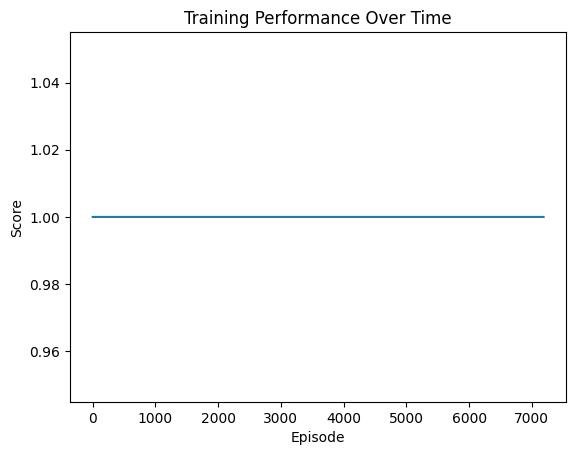

In [50]:
# Visualisasi hasil training
episodes = len(dataset['Status'])
scores = []
for episode in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action, _ = ppo.select_action(obs)
        obs, reward, done, info = env.step()
        score += reward
    scores.append(score)
    print(f"Episode: {episode}, Score: {score}")

env.close()

# Plotting the scores
plt.plot(range(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Performance Over Time')
plt.show()


   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound  tps  \
0      0.090         0.535               7.46                6.45  2.0   
1      0.166         0.533               5.85                5.27  2.2   
2      0.202         0.553               9.06                7.96  3.2   
3      0.146         0.580               8.41                7.21  3.2   
4      0.102         0.535               4.88                4.30  2.6   

   tps_error  response_time  Status  
0        0.0          0.607       0  
1        0.0          2.090       0  
2        0.0          3.450       0  
3        0.0          2.580       0  
4        0.0          0.862       0  
      Actual Status  Predicted Status
0                 0                 1
1                 0                 0
2                 0                 0
3                 0                 0
4                 0                 1
...             ...               ...
1795              0                 1
1796              0    

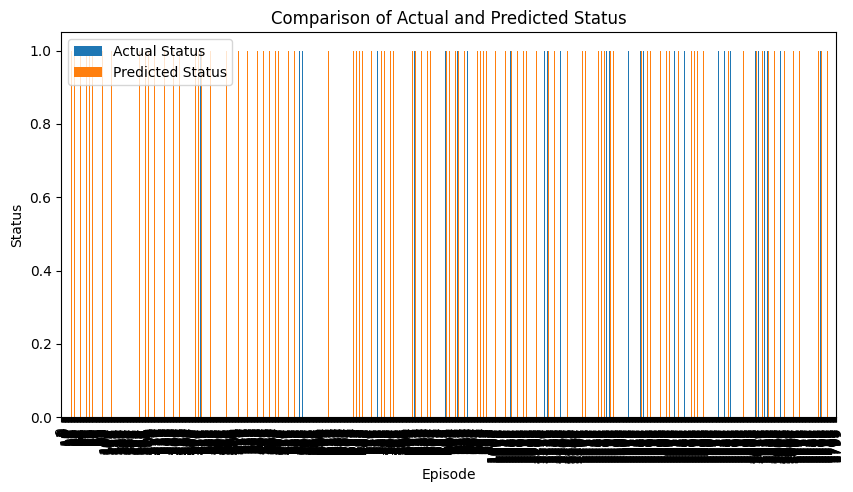

In [51]:
# Load actual data for comparison
actual_data = dataset
print(actual_data.head())

predicted_statuses = []
actual_statuses = actual_data['Status'].tolist()

def evaluate_and_compare(env, model, n_eval_episodes=10):
    episode_rewards = []
    predicted_statuses = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step()
            episode_reward += reward
            if done:
                predicted_statuses.append(action)  # Save the predicted action as the status
        episode_rewards.append(episode_reward)
    return episode_rewards, predicted_statuses

# Evaluasi dan dapatkan predicted status
mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=max_episodes)
_, predicted_statuses = evaluate_and_compare(env, ppo, n_eval_episodes=max_episodes)

# Comparison
comparison_df = pd.DataFrame({
    'Actual Status': actual_statuses[:len(predicted_statuses)],  # Ensure matching length
    'Predicted Status': predicted_statuses
})

print(comparison_df)

# Visualization
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Episode')
plt.ylabel('Status')
plt.title('Comparison of Actual and Predicted Status')
plt.show()


In [52]:
len(predicted_statuses)

1800

Confusion Matrix - Validation Data
[[611 617]
 [103 107]]


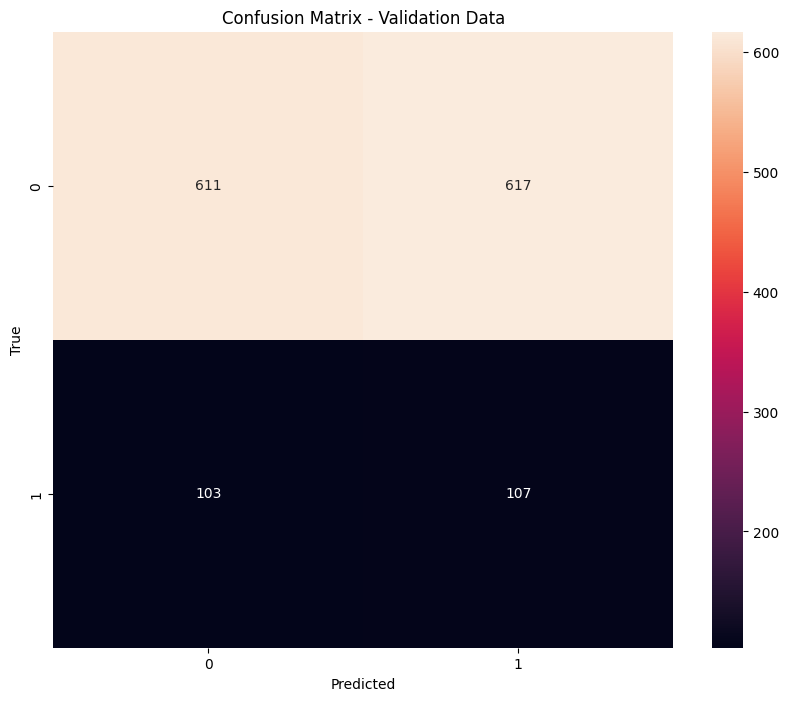

Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.86      0.50      0.63      1228
           1       0.15      0.51      0.23       210

    accuracy                           0.50      1438
   macro avg       0.50      0.50      0.43      1438
weighted avg       0.75      0.50      0.57      1438



In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Menghitung dan menampilkan confusion matrix untuk data validasi
cm_val = confusion_matrix(y_test, predicted_statuses[:1438])
print("Confusion Matrix - Validation Data")
print(cm_val)

# Menampilkan confusion matrix sebagai heatmap untuk data validasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Menghitung dan menampilkan classification report untuk data validasi
print("Classification Report - Validation Data")
report_val = classification_report(y_test, predicted_statuses[:1438])
print(report_val)

In [54]:
np.unique(predicted_statuses)

array([0, 1])

In [55]:
# from itertools import product

# # Hyperparameter grid
# learning_rates = [0.0001, 0.0003, 0.001]
# gammas = [0.95, 0.99]
# eps_clips = [0.1, 0.2]
# k_epochs_list = [3, 5]

# best_reward = -float('inf')
# best_params = None

# for lr, gamma, eps_clip, k_epochs in product(learning_rates, gammas, eps_clips, k_epochs_list):
#     ppo = PPO(state_dim, action_dim, lr=lr, gamma=gamma, k_epochs=k_epochs, eps_clip=eps_clip)
#     memory = Memory()
    
#     time_step = 0
#     total_reward = 0

#     for episode in range(1, max_episodes + 1):
#         state = env.reset()
#         episode_reward = 0
#         for t in range(max_timesteps):
#             time_step += 1
#             action, logprob = ppo.select_action(state)
#             next_state, reward, done, _ = env.step()

#             memory.add_state(torch.FloatTensor(state))
#             memory.add_action(torch.tensor(action))
#             memory.add_logprob(torch.tensor(logprob))
#             memory.add_reward(reward)
#             memory.add_is_terminal(done)
            
#             state = next_state
#             episode_reward += reward

#             if time_step % update_timestep == 0:
#                 ppo.update(memory)
#                 memory.clear_memory()
#                 time_step = 0
            
#             if done:
#                 break

#         total_reward += episode_reward

#     # Compare the total reward with the best reward so far
#     if total_reward > best_reward:
#         best_reward = total_reward
#         best_params = (lr, gamma, eps_clip, k_epochs)

# print(f"Best Hyperparameters: Learning Rate: {best_params[0]}, Gamma: {best_params[1]}, Epsilon Clip: {best_params[2]}, K Epochs: {best_params[3]}")

In [56]:
# print(f"Best Hyperparameters: Learning Rate: {best_params[0]}, Gamma: {best_params[1]}, Epsilon Clip: {best_params[2]}, K Epochs: {best_params[3]}")